# 用邻近点梯度法、交替方向乘子法、次梯度法求解 LASSO 回归模型

作者：Jed

来源：https://www.jeddd.com/article/use-python-to-solve-lasso-by-pgd-admm-and-subgd.html

时间：2019年6月

---

## 准备工作

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 使Matplotlib输出矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# 常量
A_dim = (50, 100)
x_dim = 100
x_sparsity = 5  # 稀疏度
e_dim = 50

## 随机生成数据

In [3]:
# 生成x的真值
x_nonzero_index = random.sample(range(x_dim), 5)  # 非0元素的下标
x_nonzero_element = np.random.normal(0, 1, x_sparsity)
x_real = np.zeros(x_dim)
for i in range(len(x_nonzero_element)):
    x_real[x_nonzero_index] = x_nonzero_element
x_real

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.50843196,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.02666871,  0.        ,  0.        ,  0.  

In [4]:
# 生成测量矩阵A
A = np.random.normal(0, 1, A_dim)
A

array([[-0.93154395,  1.53075473, -0.59393711, ..., -0.26073971,
        -0.59972411,  1.22168427],
       [ 0.80705458,  1.294095  ,  2.41100863, ..., -0.32017829,
         0.48203484,  0.56415311],
       [ 0.12934289,  0.08872108, -0.29093326, ..., -2.17381998,
         0.04204457, -0.80619408],
       ...,
       [ 0.89351844, -0.39484538, -1.87636594, ...,  2.10446107,
        -2.03744718, -1.60332838],
       [ 0.45823911,  0.13220471,  0.17523932, ...,  0.73102475,
        -0.86808487,  1.58373766],
       [ 1.56182882,  0.84092809,  1.15306611, ...,  1.48077917,
        -0.27306799,  0.31238365]])

In [5]:
# 生成测量噪声e
e = np.random.normal(0, 0.1, e_dim)
e

array([ 0.16756759, -0.02027526,  0.03592763, -0.01049448,  0.1275363 ,
        0.00616688, -0.00721615,  0.05376458,  0.09824767, -0.20833254,
        0.11640298, -0.00611687,  0.01661563, -0.02849558,  0.00805576,
        0.08434149, -0.1122025 ,  0.03964909, -0.28318177, -0.03101374,
       -0.11401483,  0.0301496 , -0.09239339, -0.05949146,  0.01499163,
       -0.09467894,  0.16370773,  0.08683876,  0.03536133,  0.02482169,
        0.08466819, -0.02909182,  0.07006925,  0.04346425, -0.04080042,
       -0.23241356,  0.07462225,  0.12823758, -0.05840682,  0.10207805,
        0.12495102, -0.10770556, -0.09174974, -0.05747856,  0.00173752,
        0.01405127, -0.08168189,  0.05512177, -0.12623327,  0.03456736])

In [6]:
# 计算带噪声的b
b = A @ x_real + e
b

array([ 0.24393963,  3.89483297,  0.5614545 , -0.77632831,  3.824283  ,
        1.43569996,  2.90923775, -1.93549121, -3.51956347, -3.58652331,
       -0.52845226,  5.05998547, -1.86708565,  4.22218172, -4.84771302,
        0.91247335, -4.4194689 , -1.53899711, -0.98282499,  0.08330615,
        1.4939799 ,  5.2247713 ,  4.540343  ,  3.02995495, -0.19051095,
       -2.33977964, -1.29853902, -1.85729288, -2.63498674,  3.27986388,
       -1.24301981, -3.98491962, -0.07240599, -1.09973559, -0.50506708,
        0.96488927,  4.03190133,  3.44644686, -3.15697764, -3.59764248,
       -3.16319441,  0.17162406,  3.01649182,  0.55960115,  6.98010673,
        4.21300966, -6.61493531,  6.30448188, -0.25543565, -5.2346062 ])

---

## 邻近点梯度下降法

Proximal Gradient Method，又称近端梯度法。

In [7]:
# 调参区
alpha = 0.001   # 固定步长
p = 1        # 正则化参数
epsilon = 1e-5  # 最大允许误差

In [8]:
x_k = np.zeros(x_dim)
x_k_old = np.zeros(x_dim)

plot_iteration = []  # 每步计算结果
k = 1  # 迭代次数

while k < 1e6:
    x_k_temp = x_k - alpha * A.T @ (A@x_k - b)  # 对光滑部分做梯度下降
    
    # 临近点投影（软阈值）
    for i in range(x_dim):
        if x_k_temp[i] < -alpha * p:
            x_k[i] = x_k_temp[i] + alpha * p
        elif x_k_temp[i] > alpha * p:
            x_k[i] = x_k_temp[i] - alpha * p
        else:
            x_k[i] = 0
            
    plot_iteration.append(x_k.copy())  # 记录每步计算结果
    if np.linalg.norm(x_k - x_k_old) < epsilon:
        break
    else:
        x_k_old = x_k.copy()  # 深拷贝
        k += 1
        
x_optm = x_k[:]  # 最优解
x_optm

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.69457318e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.98505562e-01,  0.00000000e+00,  2.73027659e-02,
       -7.84045945e-03,  0.00000000e+00,  2.08861842e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.82530060e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.96029534e-02,
        0.00000000e+00,  0.00000000e+00, -3.72845302e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [9]:
np.count_nonzero(x_optm)  # 稀疏度

15

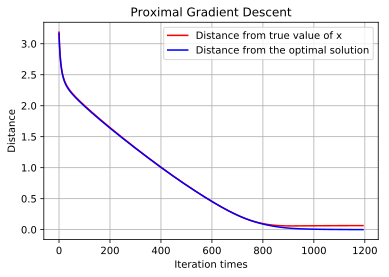

In [10]:
plot_dist_real = []  # 每步结果与真值的距离
plot_dist_optm = []  # 每步结果与最优解的距离
for iter in plot_iteration:
    plot_dist_real.append(np.linalg.norm(iter - x_real))
    plot_dist_optm.append(np.linalg.norm(iter - x_optm))

# 作图
plt.title('Proximal Gradient Descent')
plt.xlabel('Iteration times')
plt.ylabel('Distance')

plt.plot(plot_dist_real, 'r', label='Distance from true value of x')
plt.plot(plot_dist_optm, 'b', label='Distance from the optimal solution')

plt.grid()
plt.legend()
# plt.savefig('pgd_fig.svg')
plt.show()

---

## 交替方向乘子法

Alternating Direction Method of Multipliers

In [11]:
# 调参区
c = 0.005
alpha = 1/c
p = 0.01       # 正则化参数
epsilon = 1e-5  # 最大允许误差

In [12]:
x_k = np.zeros(x_dim)
y_k = np.zeros(x_dim)
v_k = np.zeros(x_dim)
x_k_old = np.zeros(x_dim)

plot_iteration = []  # 每步计算结果
k = 1  # 迭代次数

while k < 1e6:
    # 更新x
    x_k = np.linalg.inv(A.T@A + c*np.eye(x_dim, x_dim)) @ (A.T@b + c*y_k - v_k)
    
    # 更新y（软阈值）
    for i in range(x_dim):
        if x_k[i] + v_k[i]/c < -p/c:
            y_k[i] = x_k[i] + v_k[i]/c + p/c
        elif x_k[i] + v_k[i]/c > p/c:
            y_k[i] = x_k[i] + v_k[i]/c - p/c
        else:
            y_k[i] = 0
            
    # 更新v
    v_k = v_k + c * (x_k - y_k)
    
    
    plot_iteration.append(x_k.copy())  # 记录每步计算结果
    if np.linalg.norm(x_k - x_k_old) < epsilon:
        break
    else:
        x_k_old = x_k.copy()  # 深拷贝
        k += 1
        
x_optm = x_k[:]  # 最优解
x_optm

array([-3.23367034e-05, -4.45702635e-05,  1.63068827e-04,  1.30137710e-04,
        1.10916194e-04, -9.74696754e-05, -1.08635799e-04,  3.35470281e-05,
        3.40588363e-03,  3.20487723e-02,  2.96283747e-06, -1.78562768e-04,
       -5.60891496e-05,  5.28497867e-01,  2.56972367e-03, -9.24865365e-05,
       -3.86742656e-05, -8.22497731e-03,  1.47025270e-02,  1.29989497e-02,
        2.75567256e-05,  3.89464990e-05,  1.67594199e-05, -1.07409976e-04,
       -7.48541252e-05, -1.07247250e-04,  1.55073817e-05,  2.91390335e-02,
       -9.94266402e-05,  8.98277588e-03,  6.65676910e-03,  2.09621730e-02,
        2.81867201e-05, -6.71963150e-04, -1.86053636e-02, -2.84712207e-02,
        1.41869108e-04,  7.24073923e-05,  7.84314521e-03, -5.73241206e-03,
        1.51024297e-02,  1.25348682e-04, -3.84757118e-02, -3.00263746e-05,
       -5.64522276e-05,  5.73134669e-03, -1.28558349e-02, -3.17999684e-06,
        1.87484567e-02,  1.81847563e-05,  1.84491701e-02, -1.37570299e-02,
       -2.25035228e-05, -

In [13]:
np.count_nonzero(x_optm)  # 稀疏度

100

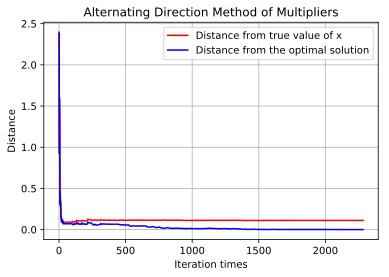

In [14]:
plot_dist_real = []  # 每步结果与真值的距离
plot_dist_optm = []  # 每步结果与最优解的距离
for iter in plot_iteration:
    plot_dist_real.append(np.linalg.norm(iter - x_real))
    plot_dist_optm.append(np.linalg.norm(iter - x_optm))

# 作图
plt.title('Alternating Direction Method of Multipliers')
plt.xlabel('Iteration times')
plt.ylabel('Distance')

plt.plot(plot_dist_real, 'r', label='Distance from true value of x')
plt.plot(plot_dist_optm, 'b', label='Distance from the optimal solution')

plt.grid()
plt.legend()
# plt.savefig('admm_fig.svg')
plt.show()

---

## 次梯度法

Subgradient Method

In [15]:
# 调参区
alpha_0 = 0.001  # 步长初值
p = 0.01         # 正则化参数
epsilon = 1e-5   # 最大允许误差

In [16]:
x_k = np.zeros(x_dim)
x_k_old = np.zeros(x_dim)

plot_iteration = []  # 每步计算结果
k = 10  # 迭代次数

while k < 1e6:
    alpha = alpha_0 / np.sqrt(k)  # 递减步长
    # 计算目标函数次梯度
    l1_subgradient = np.zeros(x_dim)  # L1范数的次梯度
    for i in range(len(x_k)):
        if x_k[i] != 0:
            l1_subgradient[i] = np.sign(l1_subgradient[i])
        else:
            l1_subgradient[i] = np.random.uniform(-1, 1)  # 随机取[-1, 1]内的值作为次梯度
    subgradient = A.T @ (A@x_k - b) + p * l1_subgradient
    
    x_k = x_k - alpha * subgradient
    
    plot_iteration.append(x_k.copy())  # 记录每步计算结果
    if np.linalg.norm(x_k - x_k_old) < epsilon:
        break
    else:
        x_k_old = x_k.copy()  # 深拷贝
        k += 1
        
x_optm = x_k.copy()  # 最优解
x_optm

array([ 0.00930911,  0.03435551, -0.05707741, -0.14520679, -0.00938263,
       -0.21404249, -0.03772045, -0.04562144,  0.20045638, -0.02583742,
       -0.16626042, -0.13495861,  0.04217496,  0.60330665, -0.22759226,
        0.13329022,  0.13738749,  0.01304147, -0.06252037, -0.21473282,
       -0.08641315,  0.3325569 , -0.08817788,  0.11847942, -0.01817634,
        0.13263954,  0.10290939, -0.03969224,  0.08350848, -0.30764987,
       -0.06862623, -0.25152463,  0.09033495,  0.18526829, -0.26812283,
        0.35845063, -0.12837782,  0.07898983, -0.10030499, -0.26344135,
        0.0665187 ,  0.33578613, -0.0778171 , -0.0371782 ,  0.05441067,
        0.23280889,  0.01763522,  0.08384515,  0.51282942, -0.10901495,
       -0.04280816, -0.25035959, -0.136563  ,  0.12617507,  0.05502624,
        0.24171725,  0.09453207, -0.06090624,  0.18176572,  0.10319462,
        0.07924876, -0.03089022,  0.1260629 , -0.06817366, -0.11041167,
        0.12316064,  0.11398565, -0.05662337,  0.03545991, -0.12

In [17]:
np.count_nonzero(x_optm)

100

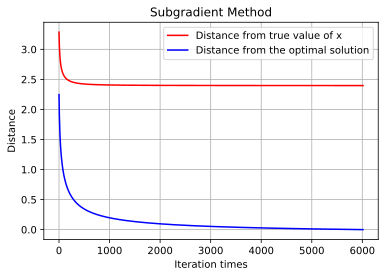

In [18]:
plot_dist_real = []  # 每步结果与真值的距离
plot_dist_optm = []  # 每步结果与最优解的距离
for iter in plot_iteration:
    plot_dist_real.append(np.linalg.norm(iter - x_real))
    plot_dist_optm.append(np.linalg.norm(iter - x_optm))

# 作图
plt.title('Subgradient Method')
plt.xlabel('Iteration times')
plt.ylabel('Distance')

plt.plot(plot_dist_real, 'r', label='Distance from true value of x')
plt.plot(plot_dist_optm, 'b', label='Distance from the optimal solution')


plt.grid()
plt.legend()
# plt.savefig('subgd_fig.svg')
plt.show()

---

作者：Jed

来源：https://www.jeddd.com/article/use-python-to-solve-lasso-by-pgd-admm-and-subgd.html